#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 15
**CH15A Predicting used car value with regression trees**

using the used-cars dataset

version 0.91 2021-01-19

In [2]:
import os
import random
import sys
import warnings
from collections import Counter
from io import StringIO

import numpy as np
import pandas as pd
import pydotplus
import statsmodels.api as sm
import pyfixest as pf
from IPython.display import Image, display
from mizani.formatters import percent_format
from patsy import dmatrices
from plotnine import *
from sklearn.inspection import permutation_importance
from sklearn.metrics import root_mean_squared_error
from sklearn.tree import  DecisionTreeRegressor, export_graphviz

warnings.filterwarnings("ignore")


In [3]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/used-cars/clean/"
data_out = dirname + "da_case_studies/ch15-used-cars-cart/"
output = dirname + "da_case_studies/ch15-used-cars-cart/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [4]:
# Import the prewritten helper functions
from py_helper_functions import *


In [5]:
# DATA IMPORT
data = pd.read_csv(data_in + "used-cars_2cities_prep.csv")
#data = pd.read_csv("https://osf.io/7gvz9/download")


In [6]:
# SAMPLE DESIGN

# Manage missing
data["fuel"] = data["fuel"].fillna("Missing")
data["drive"] = data["drive"].fillna("Missing")
data["cylinders"] = data["cylinders"].fillna("Missing")
data["transmission"] = data["transmission"].fillna("Missing")
data["type"] = data["type"].fillna("Missing")


In [7]:
data["condition"].value_counts()


condition
excellent    139
good         114
like new      55
fair          15
new            4
Name: count, dtype: int64

In [8]:
data["condition"] = data["condition"].fillna("good")


In [9]:
data["condition"].value_counts()


condition
good         336
excellent    139
like new      55
fair          15
new            4
Name: count, dtype: int64

In [10]:
# drop hybrid models then drop column
data = (data.query("Hybrid==0")).drop(["Hybrid"], axis=1)

# keep gas-fuelled vehicles
data = data.query("fuel=='gas'")

# drop vehicles in fair and new condition, trucks
data = data.query("condition not in ['new','fair']")

# drop unrealistic values for price and odometer reading
data = data.query("price in @seq(500,25001,by=1)").query("odometer<=100")

# drop if price is smaller than 1000 and condition is like new or age is less than 8
data = data.query("~(price < 1000 & (condition == 'like new'|age < 8))")

data = data.query("~(transmission=='manual')")

# drop if truck
data = data.query("type not in ['truck','pickup']")

# drop pricestr
data = data.drop(["pricestr"], axis=1)


In [11]:
# to be on the safe side
data = data[data["price"].notna()]
data = data.reset_index()


In [12]:
# DATA GENERATION & DESCRIPTIVES
# CONDITION
data["cond_excellent"] = np.where(data["condition"] == "excellent", 1, 0)
data["cond_good"] = np.where(data["condition"] == "good", 1, 0)
data["cond_likenew"] = np.where(data["condition"] == "like new", 1, 0)
# cylinders
data["cylind6"] = np.where(data["cylinders"] == "6 cylinders", 1, 0)
data.cylinders.value_counts()
data.cylind6.value_counts()
# chicago
data["chicago"] = np.where(data["area"] == "chicago", 1, 0)
# age: quadratic, cubic
data["agesq"] = data["age"] ** 2
data["agecu"] = data["age"] ** 3
# odometer quadratic
data["odometersq"] = data["odometer"] ** 3
data.to_csv("usedcars_work.csv", index=False)


In [13]:
data.price.describe()


count      477.000000
mean      5843.878407
std       4334.571604
min        500.000000
25%       2500.000000
50%       4400.000000
75%       8300.000000
max      18500.000000
Name: price, dtype: float64

In [14]:
smp_size = np.floor(0.7 * data.shape[0])


In [15]:
# Initialize random seed to make it reproducible
random.seed(42)
train_ids = random.sample(range(0, data.shape[0]), int(smp_size))

data["train"] = 0
data["train"][train_ids] = 1


In [16]:
data["train"].value_counts()


train
1    333
0    144
Name: count, dtype: int64

In [17]:
data_train = data.query("train==1")
data_test = data.query("train==0")


### Regression tree
---

In [18]:
data_train.price.describe()


count      333.000000
mean      5642.117117
std       4230.532408
min        500.000000
25%       2499.000000
50%       3999.000000
75%       7700.000000
max      17777.000000
Name: price, dtype: float64

In [19]:
cart1 = DecisionTreeRegressor(random_state=20108, max_depth=1)

# Note X should be a matrix instead of series, that's why we need double []
X = data_train[["age"]]
Y = data_train["price"]
cart1.fit(X, Y)


DecisionTreeRegressor(max_depth=1, random_state=20108)

In [20]:
pred_cart1 = cart1.predict(data_test[["age"]])

rmse_cart1 = root_mean_squared_error(data_test["price"], pred_cart1)


In [21]:
def jupyter_graphviz(m, **kwargs):
    dot_data = StringIO()
    export_graphviz(m, dot_data, **kwargs)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    display(Image(graph.create_png()))


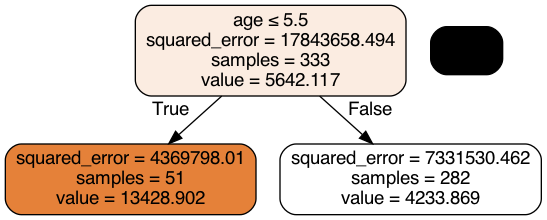

In [22]:
jupyter_graphviz(
    cart1, filled=True, rounded=True, special_characters=True, feature_names=["age"]
)


In [23]:
### Scatterplot with step function
plot_helper = seq(min(data_train["age"]), max(data_train["age"]), by=1)

plot_helper_df = pd.DataFrame({"age": plot_helper})
plot_helper_df["xend"] = pd.Series(plot_helper) + 1
plot_helper_df["yend"] = cart1.predict(plot_helper_df[["age"]])
pred_cart1t = cart1.predict(data_train[["age"]])


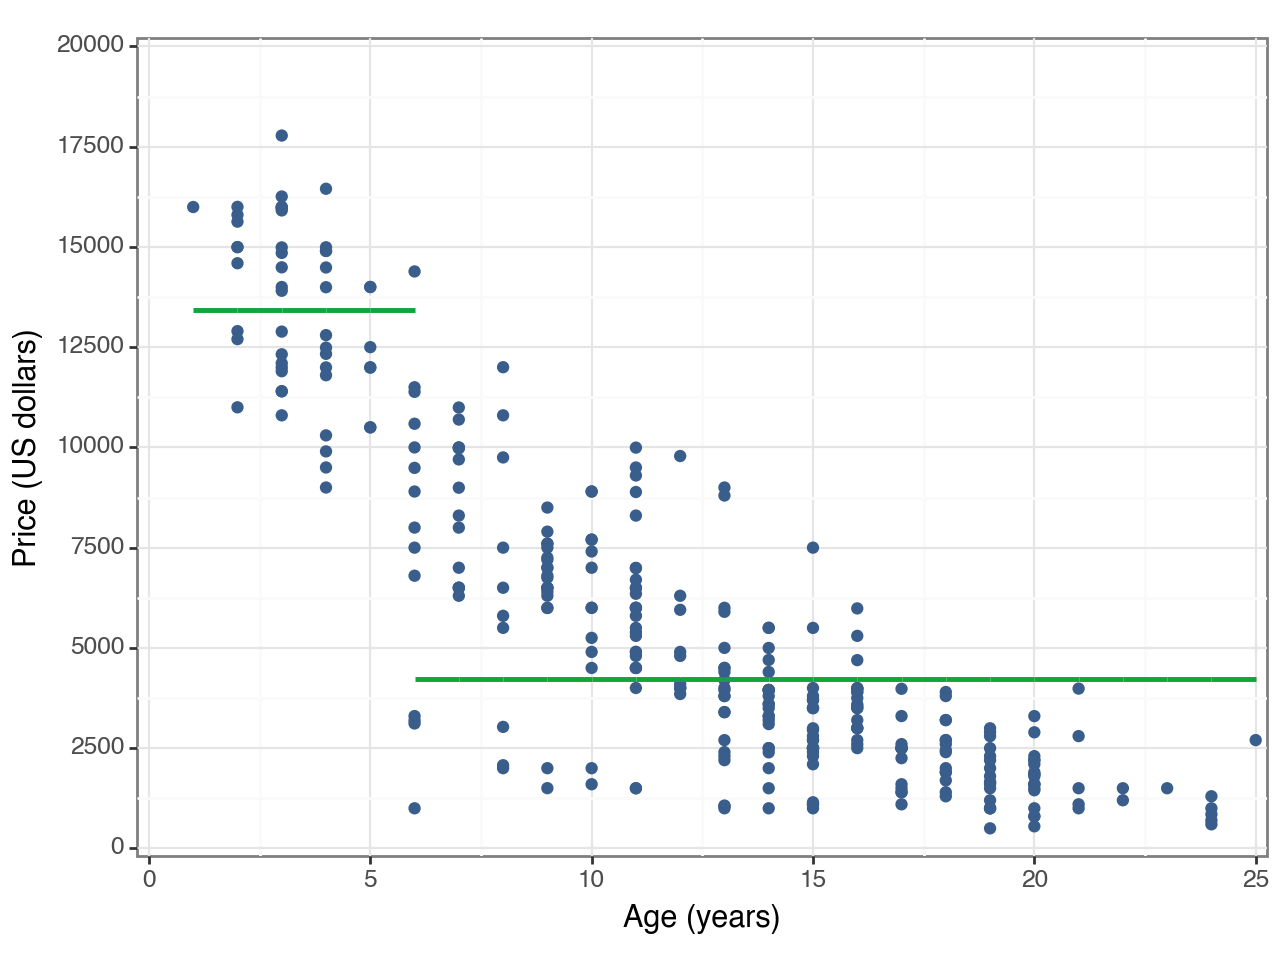

<Figure Size: (640 x 480)>

In [24]:
(
    ggplot(data_train, aes(x="age", y="price"))
    + geom_point(color=color[0])
    + geom_segment(
        plot_helper_df,
        aes(x="age", y="yend", xend="xend", yend="yend"),
        color=color[1],
        size=1,
        na_rm=True,
    )
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20001, by=2500)
    )
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 25), breaks=seq(0, 26, by=5))
    + labs(x="Age (years)", y="Price (US dollars)")
    + theme_bw()
)


In [25]:
###########
# Splits at two levels
# (make sure it stops by setting "max_depth" to 2)


In [26]:
cart2 = DecisionTreeRegressor(random_state=2018, max_depth=2)
# Note X should be a matrix instead of series, that's why we need double []
X = data_train[["age"]]
Y = data_train["price"]
cart2.fit(X, Y)


DecisionTreeRegressor(max_depth=2, random_state=2018)

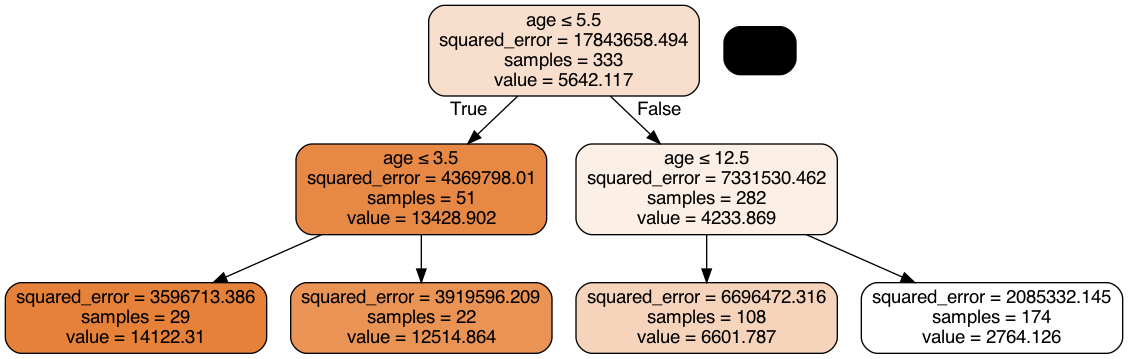

In [27]:
jupyter_graphviz(
    cart2, filled=True, rounded=True, special_characters=True, feature_names=["age"]
)


In [28]:
# Cut points
cuts = cart2.tree_.threshold[cart2.tree_.threshold != -2]

# Groups
groups = [0]
for x in cuts:
    groups += [int(np.floor(x)), int(np.floor(x) + 1)]

groups = sorted(groups) + ["or more"]


In [29]:
# get the leaf for each training sample
leaves_index = cart2.apply(X)

# use Counter to find the number of elements on each leaf
cnt = Counter(sorted(leaves_index))

# and now you can index each input to get the number of elements
elems = [cnt[x] for x in leaves_index]


In [30]:
counts = list(cnt.values())


In [31]:
av_price = (
    pd.DataFrame({"index": leaves_index, "fit": cart2.predict(X)})
    .drop_duplicates()
    .sort_values("index")["fit"]
    .tolist()
)


In [32]:
pd.DataFrame(
    {
        "Category": [
            y
            for x, y in enumerate(
                [
                    "Age " + str(groups[i]) + "-" + str(groups[i + 1])
                    for i in range(len(groups) - 1)
                ]
            )
            if x % 2 == 0
        ],
        "Count": counts,
        "Average_price": av_price,
    }
)


Category  Count  Average_price
0         Age 0-3     29   14122.310345
1         Age 4-5     22   12514.863636
2        Age 6-12    108    6601.787037
3  Age 13-or more    174    2764.126437

In [33]:
data_train.loc[(data_train.age > 1) & (data_train.age < 12), :].shape


(148, 31)

In [34]:
pred_cart2 = cart2.predict(data_test[["age"]])

rmse_cart2 = root_mean_squared_error(data_test["price"], pred_cart2)


In [35]:
### Scatterplot with step function
plot_helper = seq(min(data_train["age"]), max(data_train["age"]), by=1)

plot_helper_df = pd.DataFrame({"age": plot_helper})
plot_helper_df["xend"] = pd.Series(plot_helper) + 1
plot_helper_df["yend"] = cart2.predict(plot_helper_df[["age"]])
pred_cart1t = cart2.predict(data_train[["age"]])


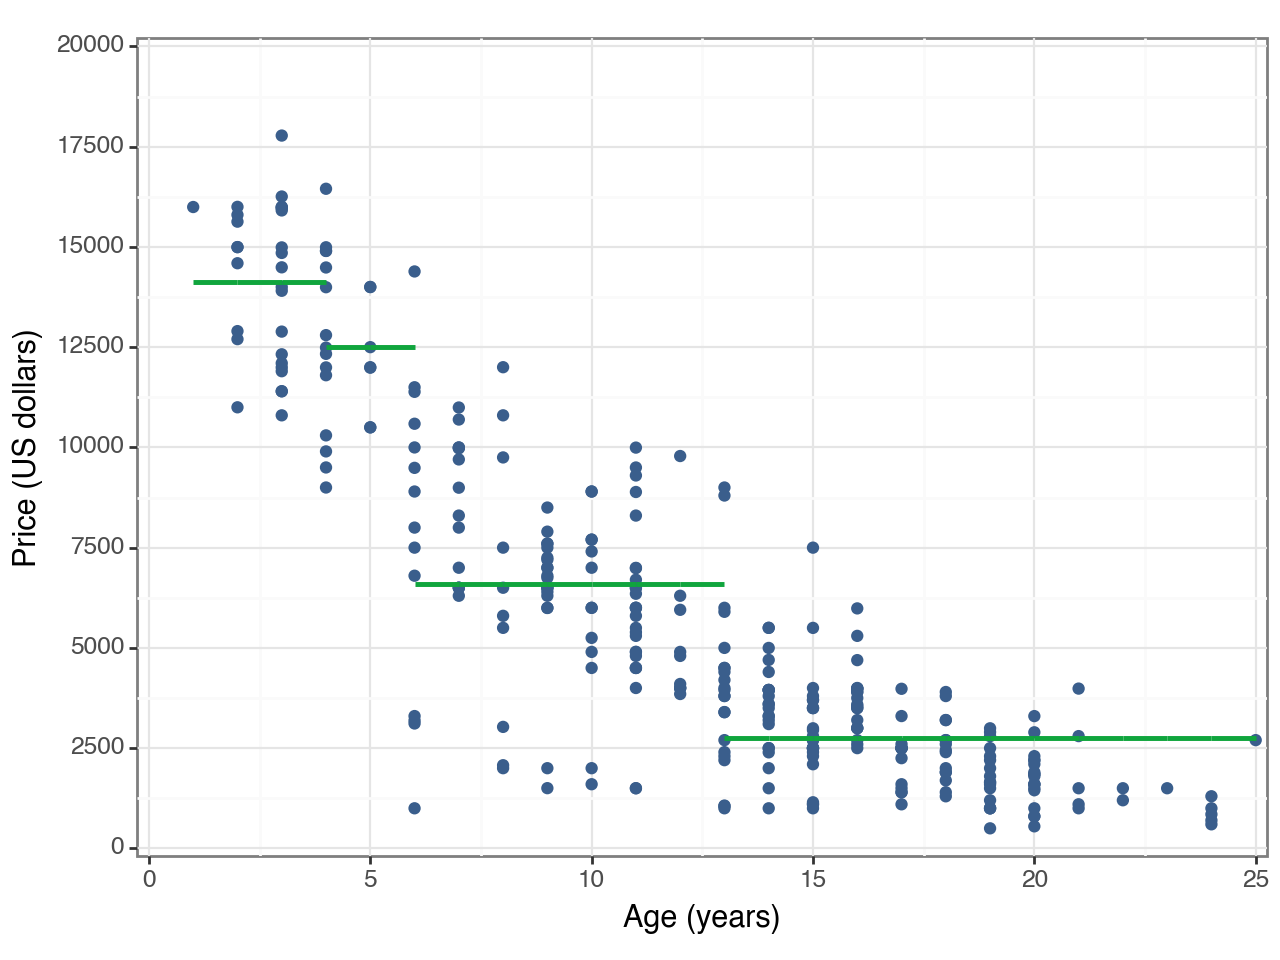

<Figure Size: (640 x 480)>

In [36]:
(
    ggplot(data_train, aes(x="age", y="price"))
    + geom_point(color=color[0])
    + geom_segment(
        plot_helper_df,
        aes(x="age", y="yend", xend="xend", yend="yend"),
        color=color[1],
        size=1,
        na_rm=True,
    )
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20001, by=2500)
    )
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 25), breaks=seq(0, 26, by=5))
    + labs(x="Age (years)", y="Price (US dollars)")
    + theme_bw()
)


**Note**: min_impurity_decrease in sklearn is considered to be the same as cp in caret, the actual values are different but the purpose is the same

In [37]:
cart3 = DecisionTreeRegressor(
    random_state=2018, min_impurity_decrease=50000
)
# Note X should be a matrix instead of series, that's why we need double []
X = data_train[["age"]]
Y = data_train["price"]
cart3.fit(X, Y)


DecisionTreeRegressor(min_impurity_decrease=50000, random_state=2018)

In [38]:
pred_cart3 = cart3.predict(data_test[["age"]])

rmse_cart3 = root_mean_squared_error(data_test["price"], pred_cart3)
rmse_cart3


1965.104039943207

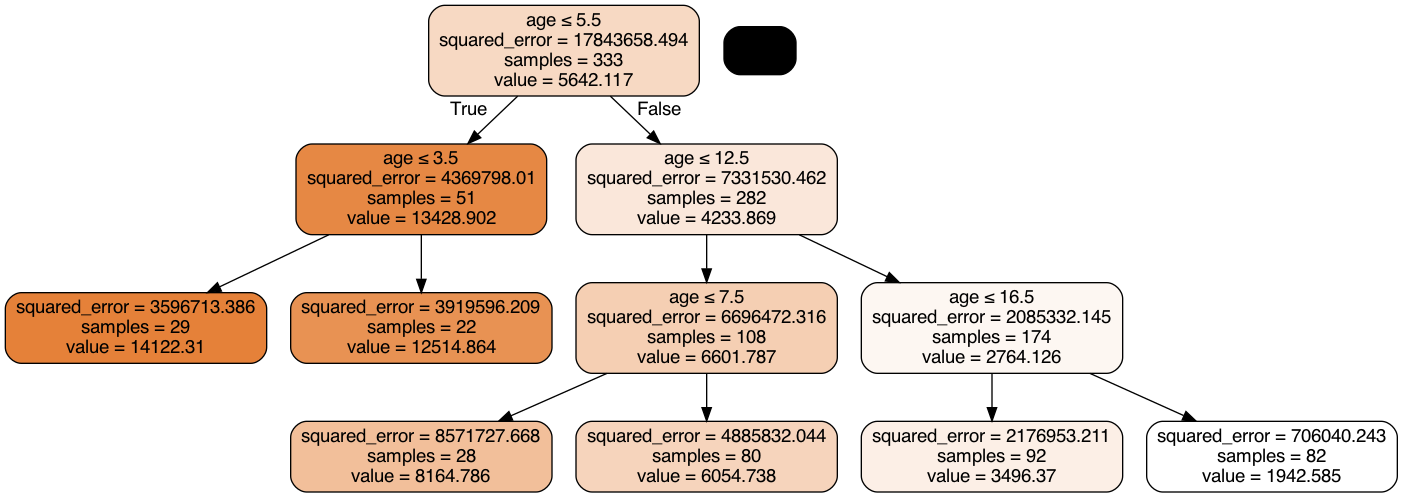

In [39]:
jupyter_graphviz(
    cart3, filled=True, rounded=True, special_characters=True, feature_names=["age"]
)


In [40]:
### Scatterplot with step function
plot_helper = seq(min(data_train["age"]), max(data_train["age"]), by=1)

plot_helper_df = pd.DataFrame({"age": plot_helper})
plot_helper_df["xend"] = pd.Series(plot_helper) + 1
plot_helper_df["yend"] = cart3.predict(plot_helper_df[["age"]])
pred_cart1t = cart3.predict(data_train[["age"]])


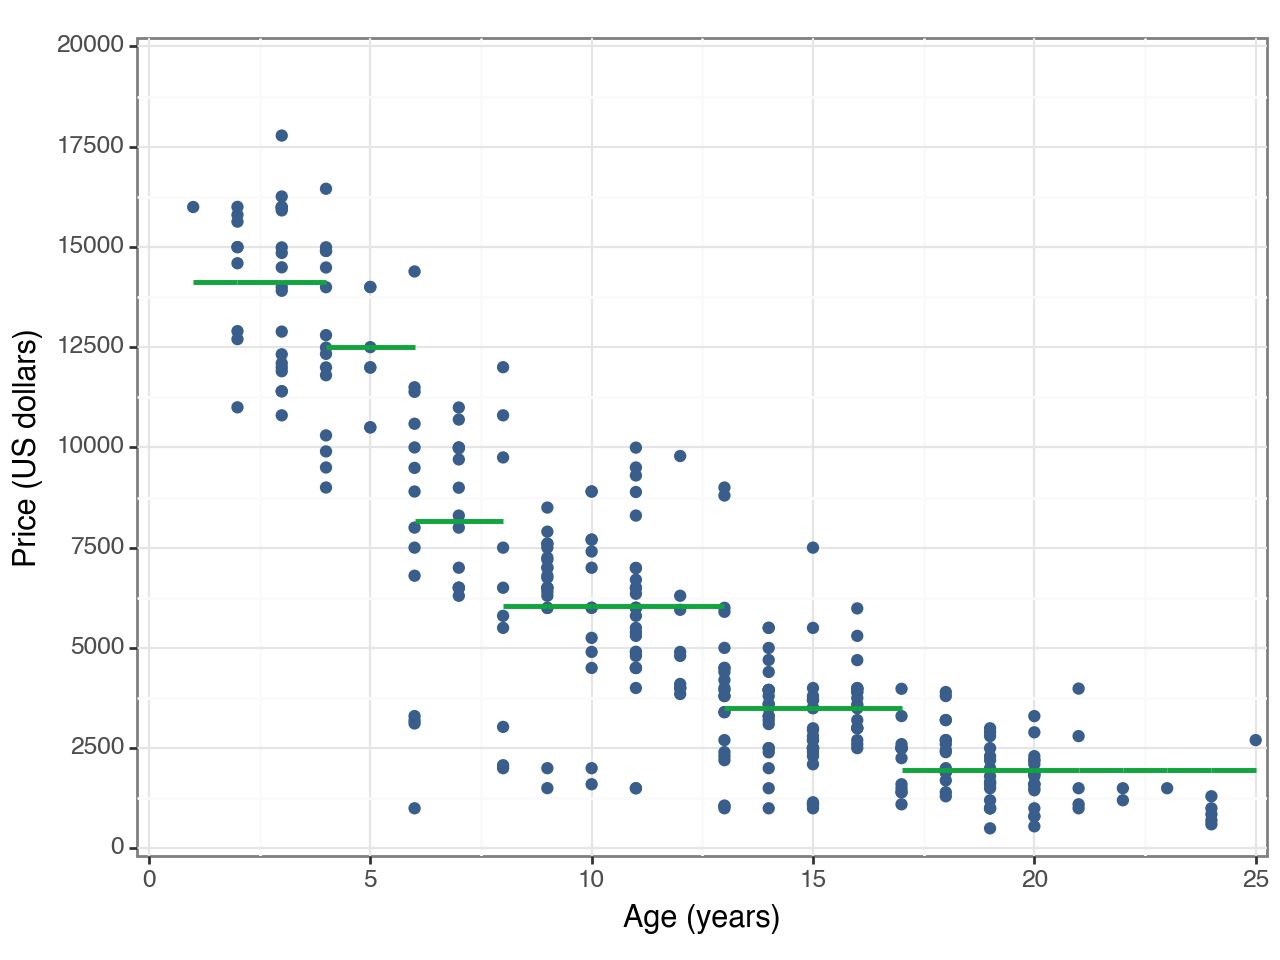

<Figure Size: (640 x 480)>

In [41]:
(
    ggplot(data_train, aes(x="age", y="price"))
    + geom_point(color=color[0])
    + geom_segment(
        plot_helper_df,
        aes(x="age", y="yend", xend="xend", yend="yend"),
        color=color[1],
        size=1,
        na_rm=True,
    )
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20000, by=2500)
    )
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 25), breaks=seq(0, 25, by=5))
    + labs(x="Age (years)", y="Price (US dollars)")
    + theme_bw()
)


#### Age only linear regression
---

In [42]:
linreg1 = pf.feols("price~age", data=data_train)
linreg1.summary()


###

Estimation:  OLS
Dep. var.: price, Fixed effects: 0
Inference:  iid
Observations:  333

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |      2.5% |     97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|----------:|----------:|
| Intercept     |  13300.573 |      293.478 |    45.320 |      0.000 | 12723.255 | 13877.891 |
| age           |   -621.713 |       21.593 |   -28.793 |      0.000 |  -664.189 |  -579.237 |
---
RMSE: 2256.426 R2: 0.715 


In [43]:
pred_linreg1 = linreg1.predict(data_test)
rmse_ols1 = root_mean_squared_error(data_test["price"], pred_linreg1)
rmse_ols1


2377.2866034443737

In [44]:
## Scatterplot with predicted values
pred_linreg1t = linreg1.predict(data_train)


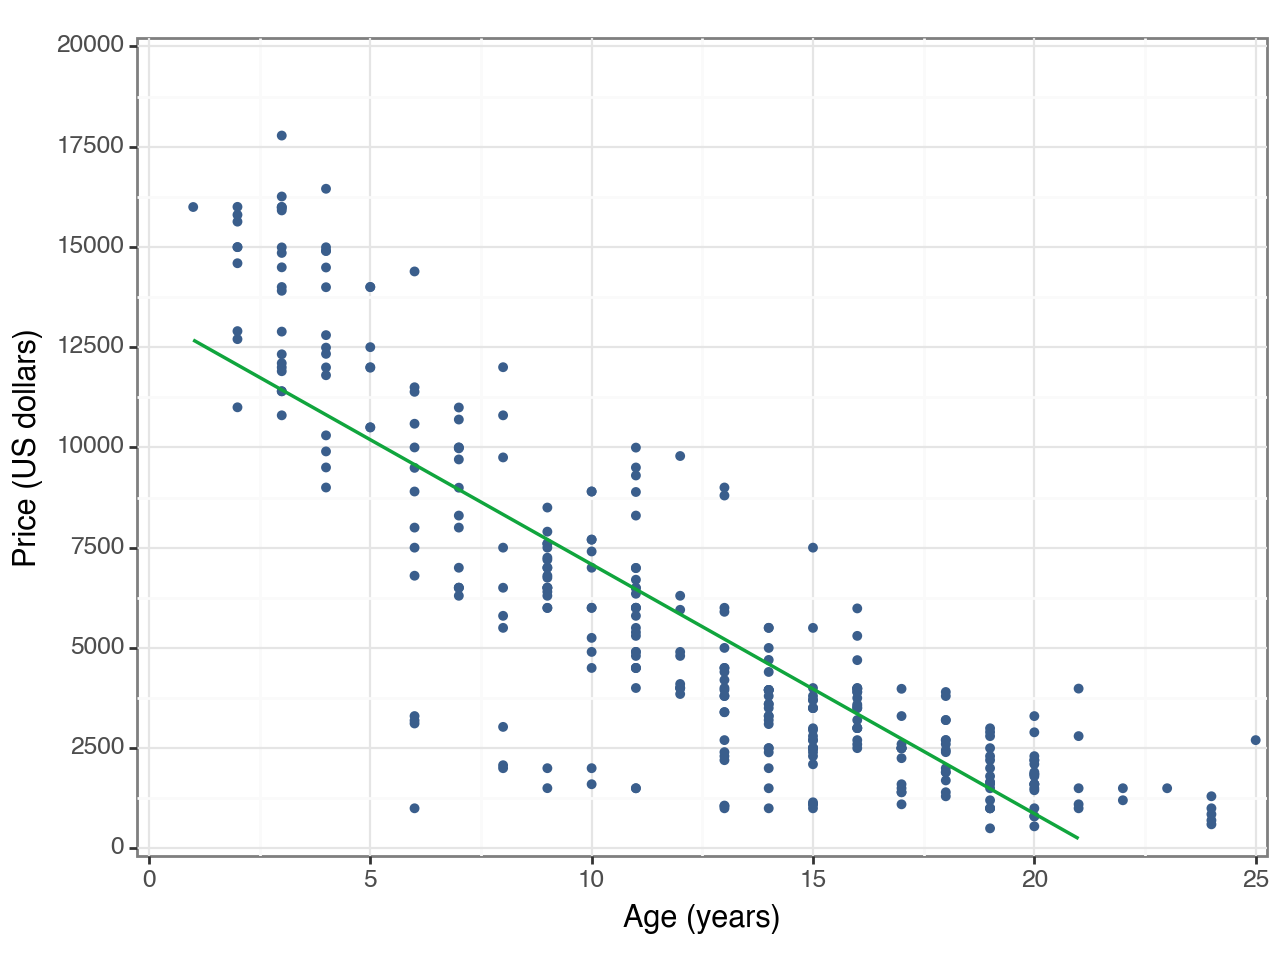

<Figure Size: (640 x 480)>

In [45]:
(
    ggplot(data_train)
    + geom_point(
        aes(x="age", y="price"),
        color=color[0],
        size=1,
        alpha=0.7,
        show_legend=False,
        na_rm=True,
    )
    + geom_line(aes(x="age", y="pred_linreg1t"), colour=color[1], size=0.7)
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20000, by=2500)
    )
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 25), breaks=seq(0, 25, by=5))
    + labs(x="Age (years)", y="Price (US dollars)")
    + theme_bw()
)


In [46]:
#### Age only only lowess
lowess = sm.nonparametric.KernelReg


In [47]:
lowess1 = lowess(data_train.price, data_train.age, "c")


In [48]:
pred_lowess1 = lowess1.fit(data_test["age"])
rmse_lowess1 = root_mean_squared_error(data_test["price"], pred_lowess1[0])
pred_lowess1t = lowess1.fit(data_train["age"])


In [49]:
data_lowess = data_train.copy()
data_lowess["pred_lowess1t"] = pred_lowess1t[0]


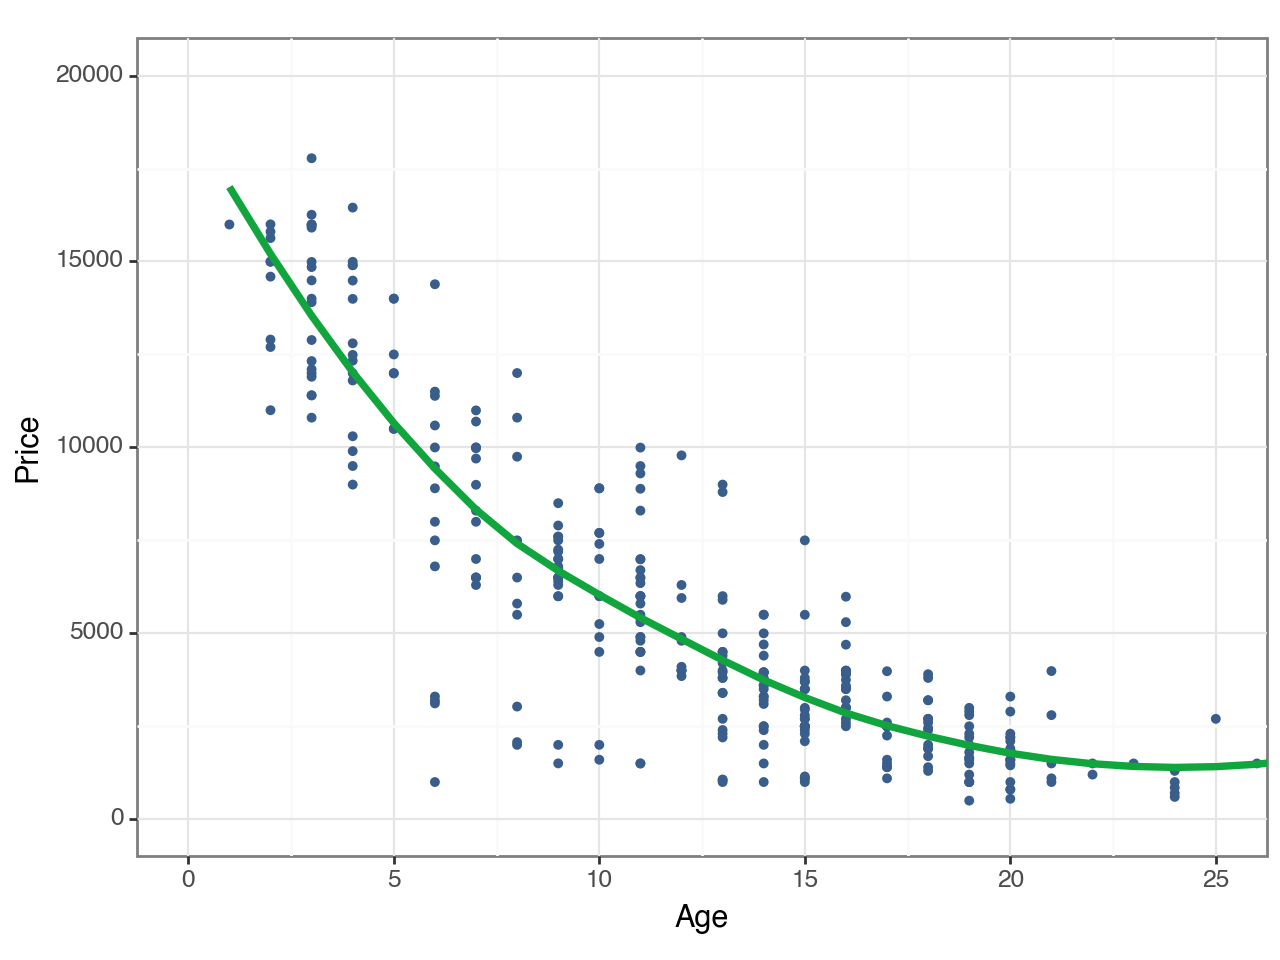

<Figure Size: (640 x 480)>

In [50]:
(
    ggplot(data_train, aes(x="age", y="price"))
    + geom_point(size=1, colour=color[0])
    + labs(x="Age", y="Price")
    + coord_cartesian(xlim=(0, 25), ylim=(0, 20000))
    + geom_smooth(method="loess", colour=color[1], se=False, size=1.5)
    + theme_bw()
)


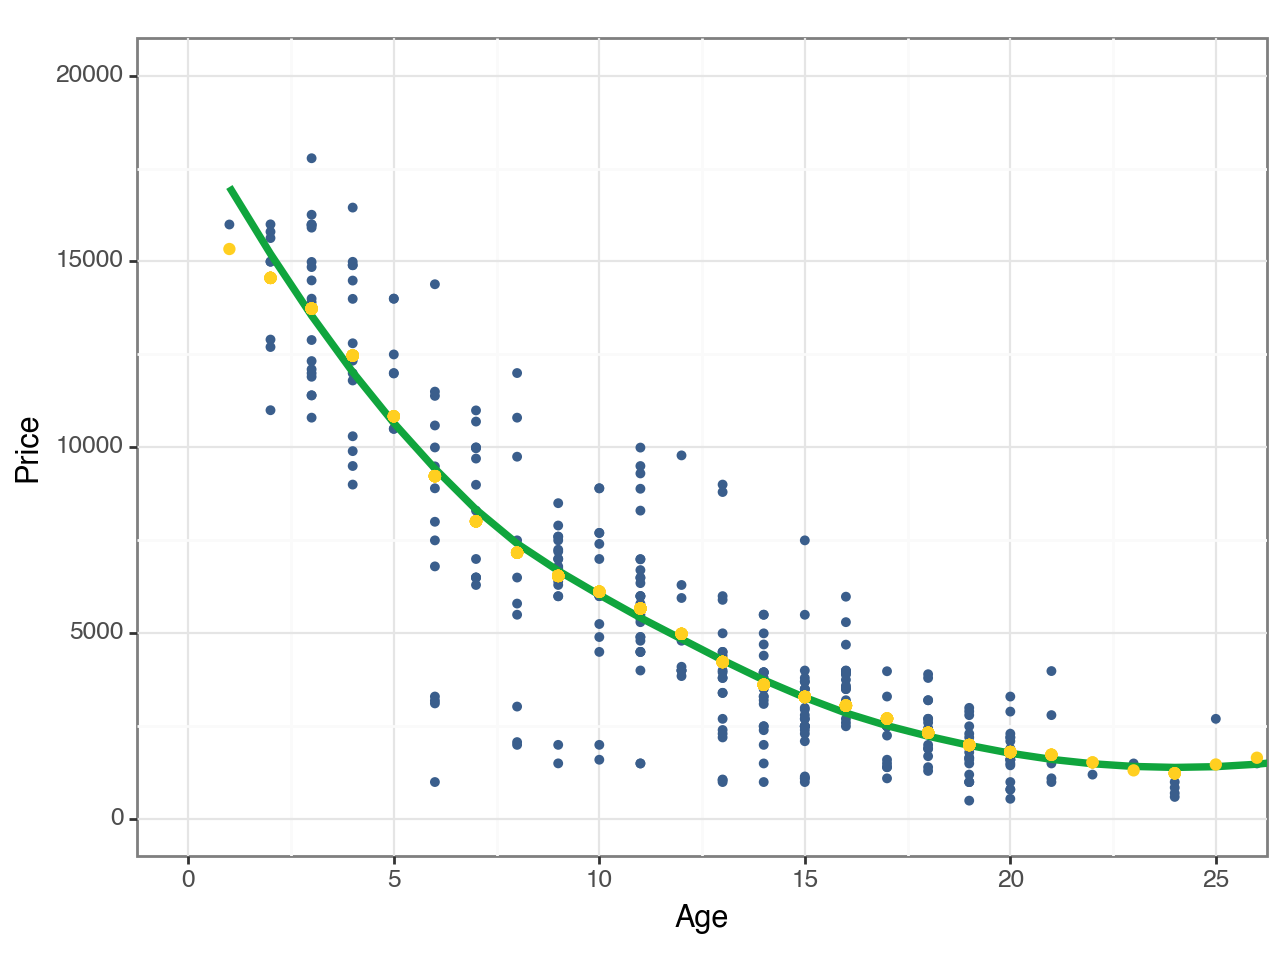

<Figure Size: (640 x 480)>

In [51]:
### Checking kernelreg predictions (yellow points) - they look the same as loess method results.
(
    ggplot(data_lowess, aes(x="age", y="price"))
    + geom_point(size=1, colour=color[0])
    + labs(x="Age", y="Price")
    + coord_cartesian(xlim=(0, 25), ylim=(0, 20000))
    + geom_smooth(method="loess", colour=color[1], se=False, size=1.5)
    + theme_bw()
    + geom_point(aes(x="age", y="pred_lowess1t"), color=color[3])
)


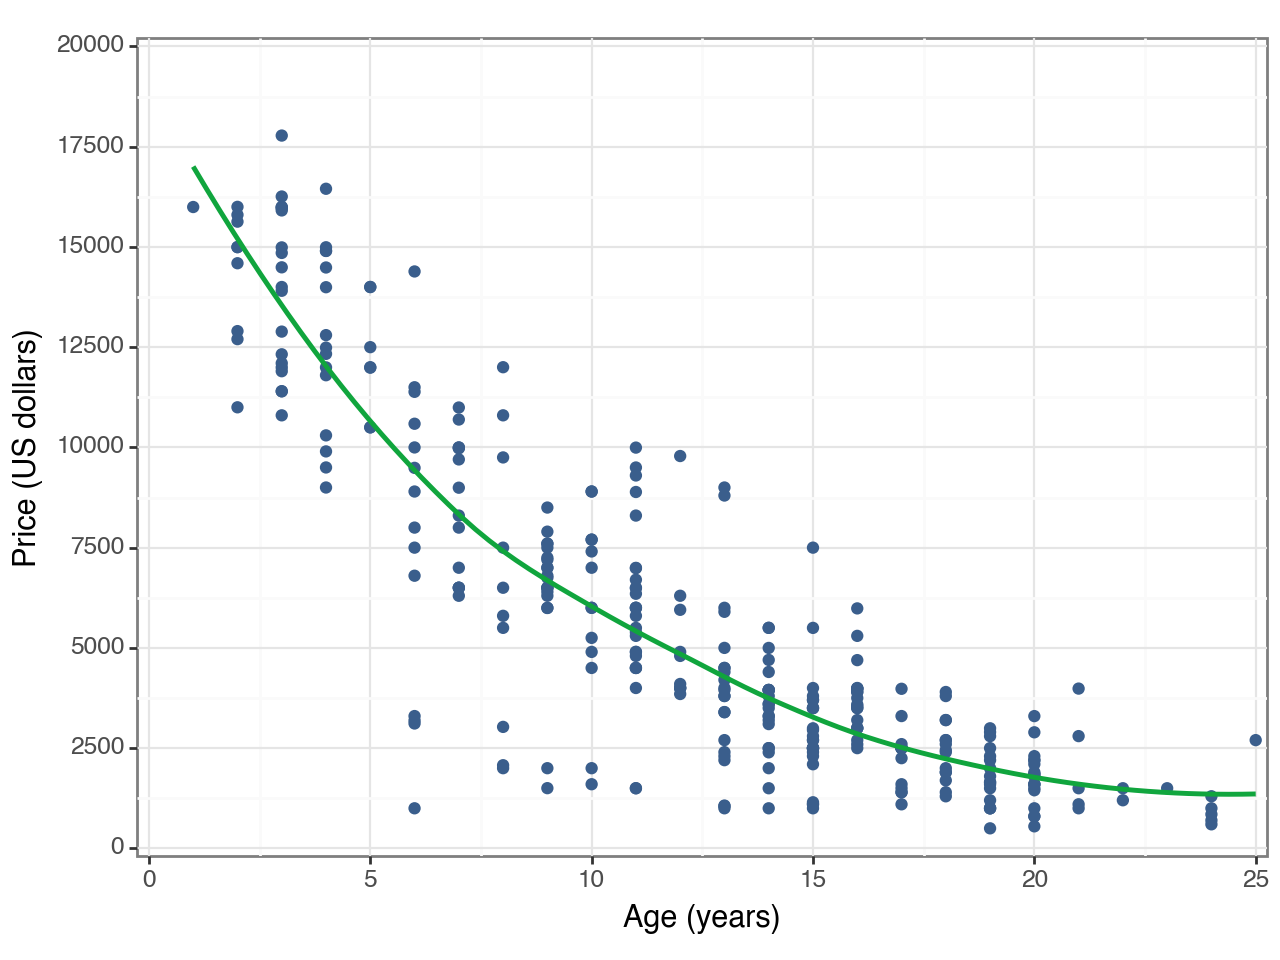

<Figure Size: (640 x 480)>

In [52]:
(
    ggplot(data_train, aes(x="age", y="price"))
    + geom_point(color=color[0])
    + geom_smooth(color=color[1], method="loess", se=False)
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20000, by=2500)
    )
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 25), breaks=seq(0, 25, by=5))
    + labs(x="Age (years)", y="Price (US dollars)")
    + theme_bw()
)


### MULTIPLE PREDICTOR VARIABLES

In [53]:
# Linear regression with multiple variables
model2 = "price ~ age + odometer + LE + XLE + SE + cond_excellent + cond_good + cylind6 + dealer + chicago"
linreg2 = pf.feols(model2, data_train)
linreg2.summary()


###

Estimation:  OLS
Dep. var.: price, Fixed effects: 0
Inference:  iid
Observations:  333

| Coefficient    |   Estimate |   Std. Error |   t value |   Pr(>|t|) |      2.5% |     97.5% |
|:---------------|-----------:|-------------:|----------:|-----------:|----------:|----------:|
| Intercept      |  13207.239 |      461.517 |    28.617 |      0.000 | 12299.270 | 14115.208 |
| age            |   -379.845 |       27.716 |   -13.705 |      0.000 |  -434.373 |  -325.317 |
| odometer       |   -291.200 |       31.750 |    -9.172 |      0.000 |  -353.663 |  -228.737 |
| LE             |   -181.084 |      254.473 |    -0.712 |      0.477 |  -681.723 |   319.555 |
| XLE            |     25.226 |      412.679 |     0.061 |      0.951 |  -786.661 |   837.114 |
| SE             |    637.554 |      379.765 |     1.679 |      0.094 |  -109.579 |  1384.688 |
| cond_excellent |    438.724 |      404.772 |     1.084 |      0.279 |  -357.607 |  1235.055 |
| cond_good      |    416.629 |      382.73

In [54]:
pred_linreg2 = linreg2.predict(data_test)
rmse_linreg2 = root_mean_squared_error(data_test["price"], pred_linreg2)
rmse_linreg2


1932.0603451582538

In [55]:
# add squared for age, odometer
model3 = "price ~ age + agesq+ odometer+odometersq +LE + XLE + SE + cond_excellent + cond_good + cylind6 + dealer+chicago"
linreg3 = pf.feols(model3, data_train)
linreg3.summary()


###

Estimation:  OLS
Dep. var.: price, Fixed effects: 0
Inference:  iid
Observations:  333

| Coefficient    |   Estimate |   Std. Error |   t value |   Pr(>|t|) |      2.5% |     97.5% |
|:---------------|-----------:|-------------:|----------:|-----------:|----------:|----------:|
| Intercept      |  16667.257 |      519.450 |    32.086 |      0.000 | 15645.288 | 17689.225 |
| age            |   -868.112 |       84.942 |   -10.220 |      0.000 | -1035.228 |  -700.996 |
| agesq          |     18.493 |        2.902 |     6.371 |      0.000 |    12.782 |    24.203 |
| odometer       |   -438.923 |       57.365 |    -7.651 |      0.000 |  -551.783 |  -326.063 |
| odometersq     |      0.376 |        0.082 |     4.579 |      0.000 |     0.214 |     0.538 |
| LE             |    -15.663 |      221.131 |    -0.071 |      0.944 |  -450.718 |   419.392 |
| XLE            |    -19.804 |      357.915 |    -0.055 |      0.956 |  -723.967 |   684.358 |
| SE             |    387.537 |      335.13

In [56]:
pred_linreg3 = linreg3.predict(data_test)
rmse_linreg3 = root_mean_squared_error(data_test["price"], pred_linreg3)
rmse_linreg3


1425.6803556119996

In [57]:
Y, X = dmatrices(model2, data_train)


In [58]:
# Tree

# Splits at four levels, for illustrative purposes
# (make sure it stops by setting "maxdepth" to 3)
cart4 = DecisionTreeRegressor(random_state=20108, max_depth=3)
cart4.fit(X, Y)


DecisionTreeRegressor(max_depth=3, random_state=20108)

In [59]:
y_test, X_test = dmatrices(model2, data_test)

pred_cart4 = cart4.predict(X_test)
rmse_cart4 = root_mean_squared_error(y_test, pred_cart4)
rmse_cart4


1947.937392219142

In [60]:
feature_names_model2 = [
    "price",
    "age",
    "odometer",
    "LE",
    "XLE",
    "SE",
    "cond_excellent",
    "cond_good",
    "cylind6",
    "dealer",
    "chicago",
]


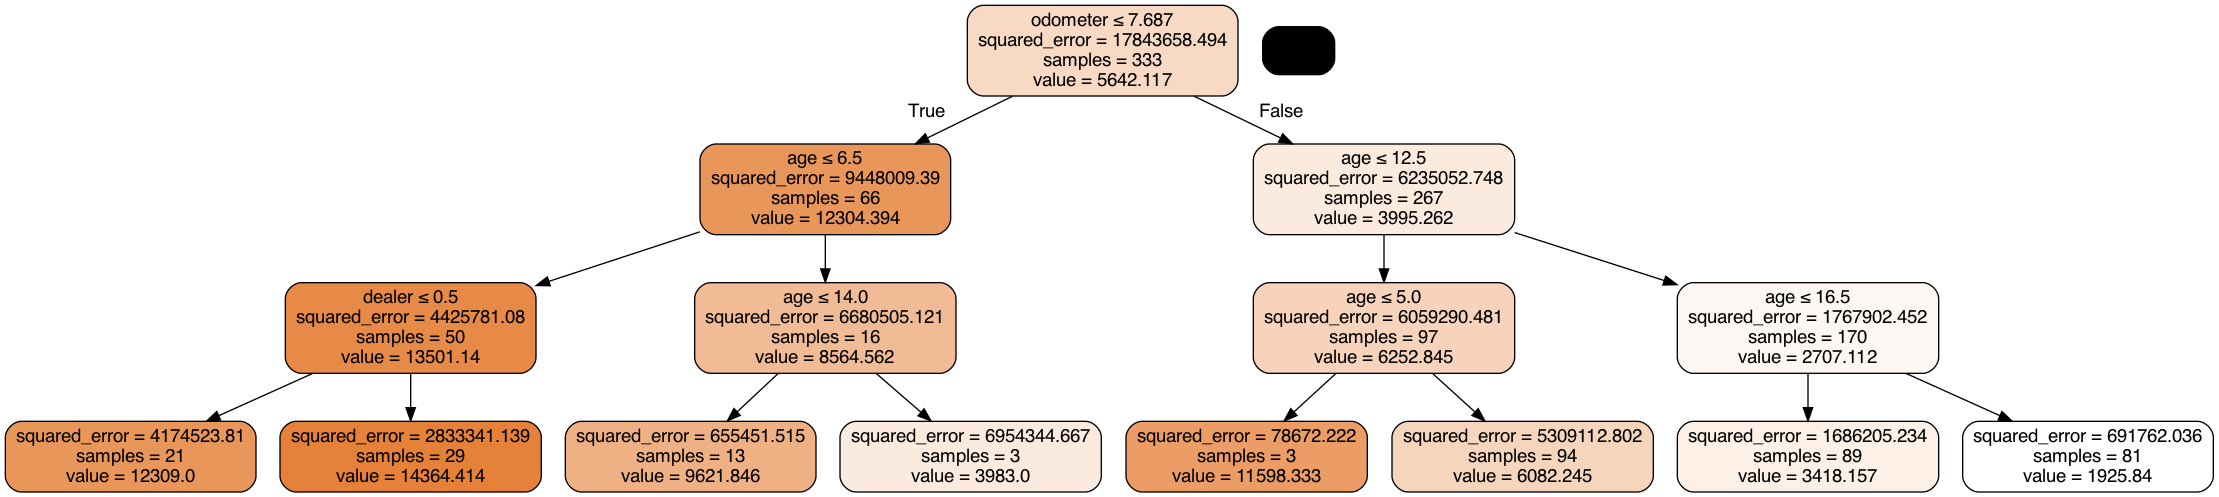

In [61]:
jupyter_graphviz(
    cart4,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=feature_names_model2,
)


In [62]:
# alternative to show the use of min_impurity_decrease
# slightly the same outcome


In [63]:
cart4 = DecisionTreeRegressor(
    random_state=20108,
    min_impurity_decrease=145000,
    min_samples_split=20,
)
cart4.fit(X, Y)

y_test, X_test = dmatrices(model2, data_test)

pred_cart4 = cart4.predict(X_test)
rmse_cart4 = root_mean_squared_error(y_test, pred_cart4)
rmse_cart4


1924.2761573035132

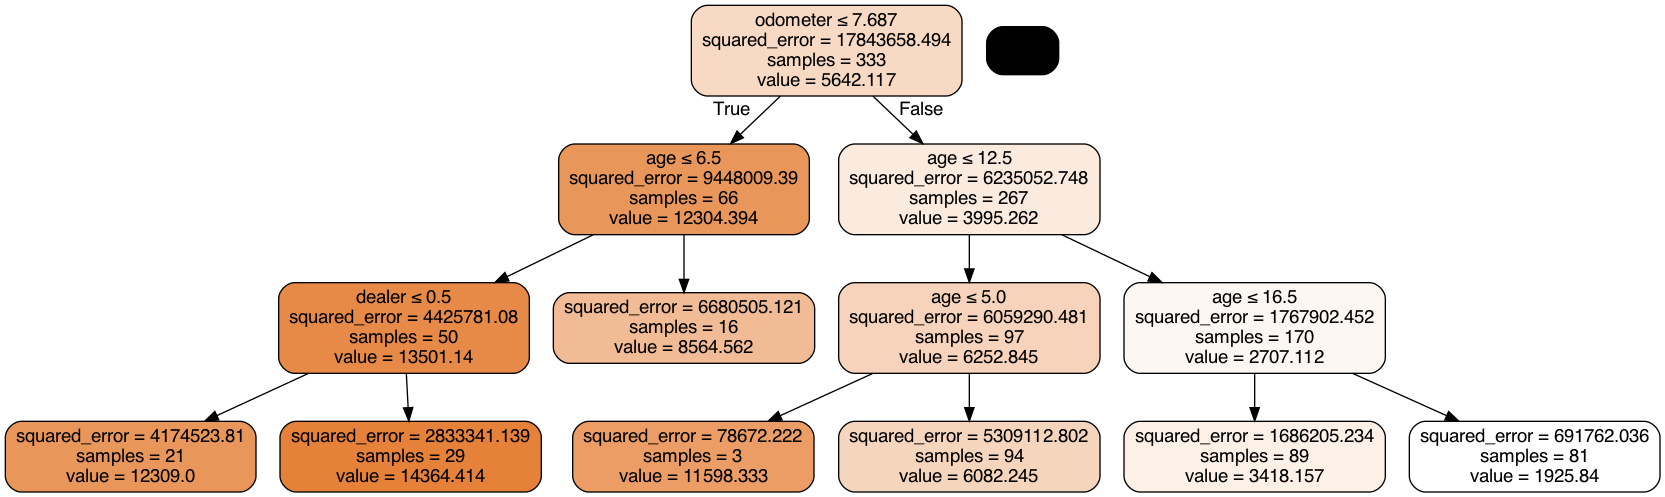

In [64]:
jupyter_graphviz(
    cart4,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=feature_names_model2,
)


In [65]:
# CART M5
cart5 = DecisionTreeRegressor(
    random_state=20108,
    min_impurity_decrease=20000,
)
cart5.fit(X, Y)


DecisionTreeRegressor(min_impurity_decrease=20000, random_state=20108)

In [66]:
pred_cart5 = cart5.predict(X_test)
rmse_cart5 = root_mean_squared_error(y_test, pred_cart5)
rmse_cart5


1873.370022392691

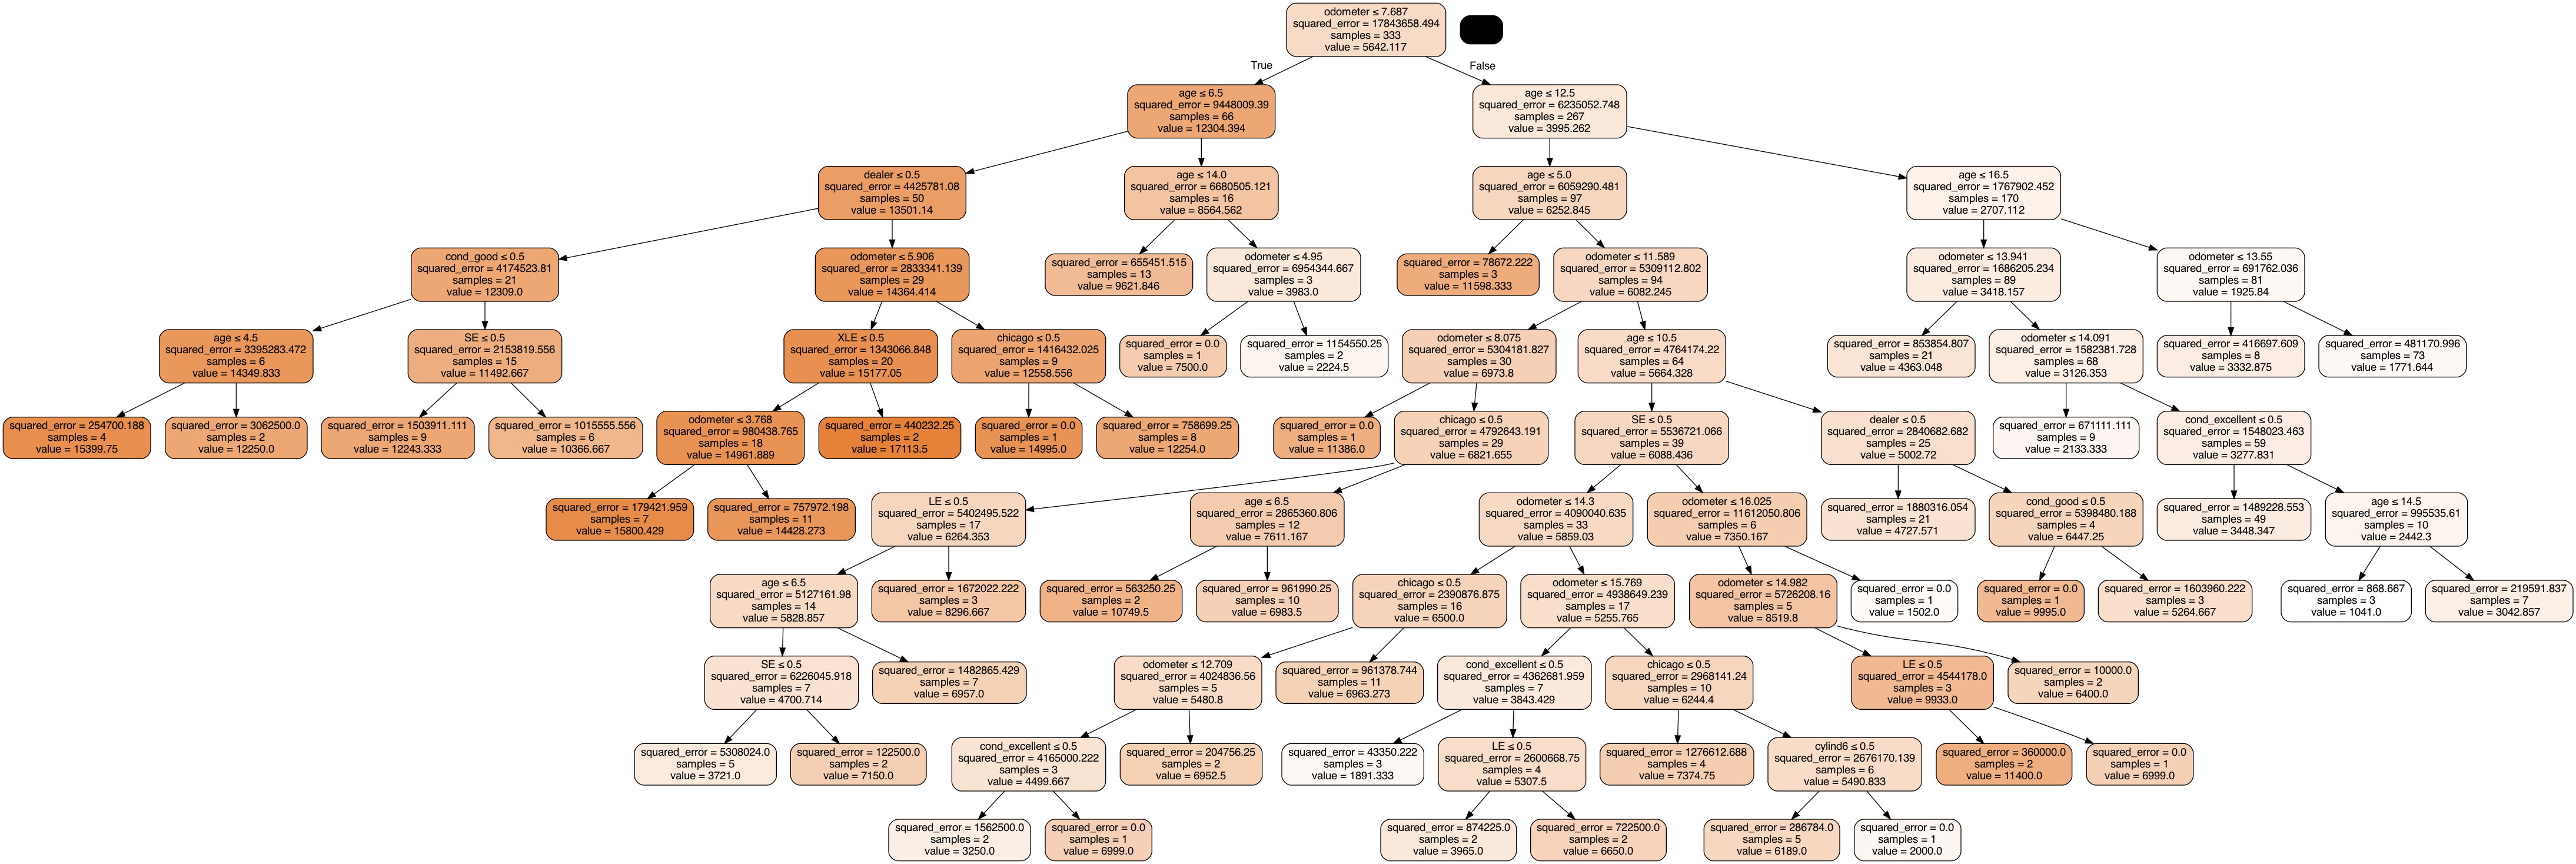

In [67]:
jupyter_graphviz(
    cart5,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=feature_names_model2,
)


In [68]:
# build very large tree and prune it
# in Python this can be done in sklearn's DecisionTreeRegressor with ccp_alpha parameter
cart6 = DecisionTreeRegressor(
    random_state=20108, min_samples_split=4, ccp_alpha=30000
)
cart6.fit(X, Y)


DecisionTreeRegressor(ccp_alpha=30000, min_samples_split=4, random_state=20108)

In [69]:
pred_cart6 = cart6.predict(X_test)
rmse_cart6 = root_mean_squared_error(y_test, pred_cart6)
rmse_cart6


1691.655225956562

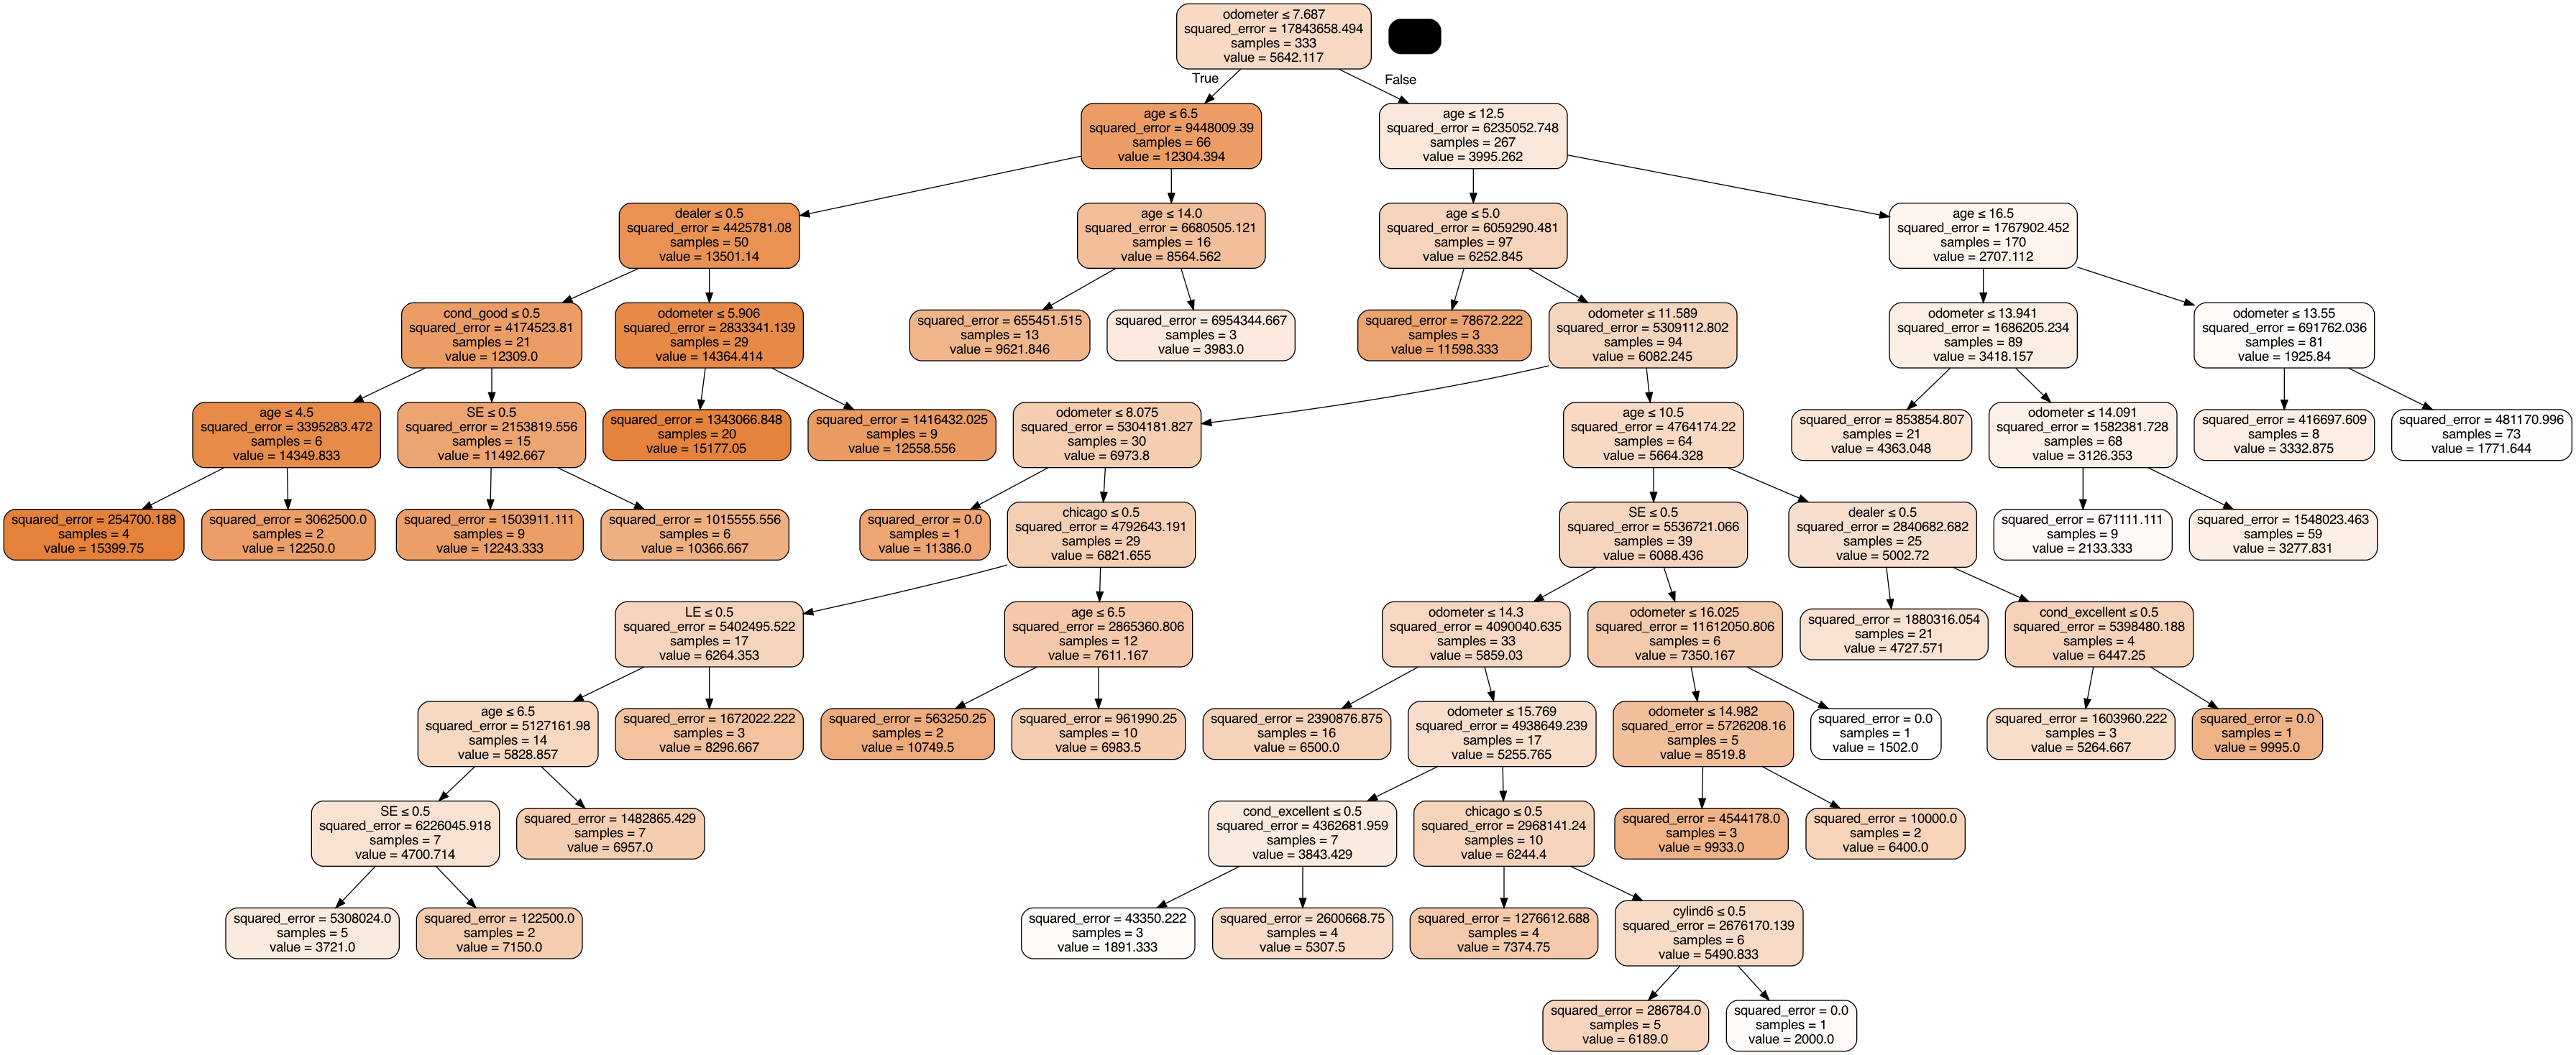

In [70]:
jupyter_graphviz(
    cart6,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=feature_names_model2,
)


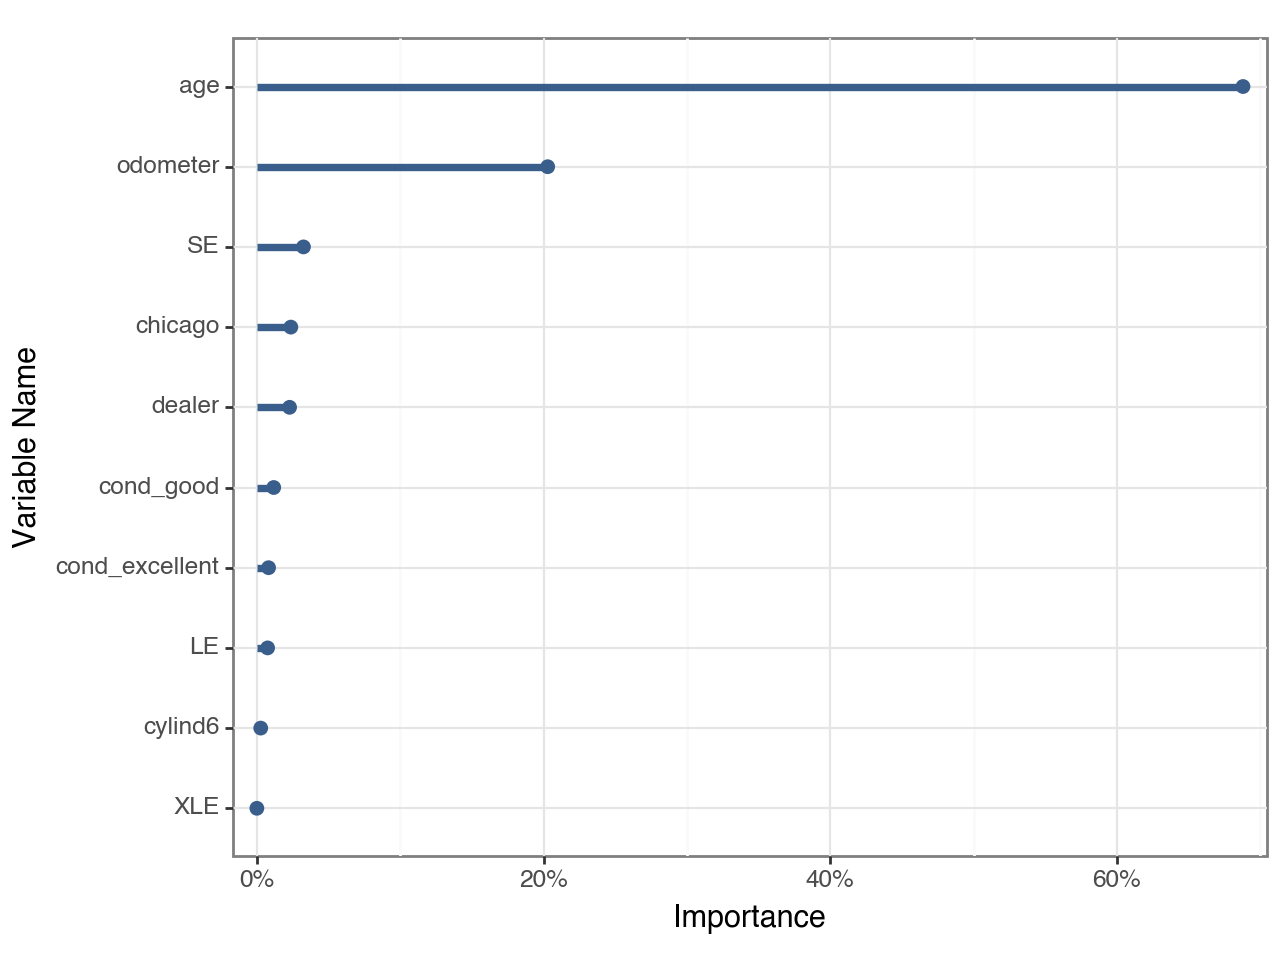

<Figure Size: (640 x 480)>

In [71]:
# Variable (permutation) importance for model 6 (not in book)

perm_imp = permutation_importance(cart6, X, Y, n_repeats=500, scoring="r2")

cart4_var_imp_df = (
    pd.DataFrame(perm_imp["importances_mean"], feature_names_model2)
    .iloc[1:, :]
    .rename({0: "Importance"}, axis=1)
    .sort_values(by=["Importance"], ascending=False)
    .reset_index()
)

cart4_var_imp_df["Importance"] = (
    cart4_var_imp_df["Importance"] / cart4_var_imp_df["Importance"].sum()
)

(
    ggplot(cart4_var_imp_df, aes(x="reorder(index,Importance)", y="Importance"))
    + geom_point(color=color[0], size=2)
    + geom_segment(
        aes(x="index", xend="index", y=0, yend="Importance"), color=color[0], size=1.5
    )
    + ylab("Importance")
    + xlab("Variable Name")
    + coord_flip()
    + scale_y_continuous(expand=(0.01, 0.01), labels=percent_format())
    + theme_bw()
)


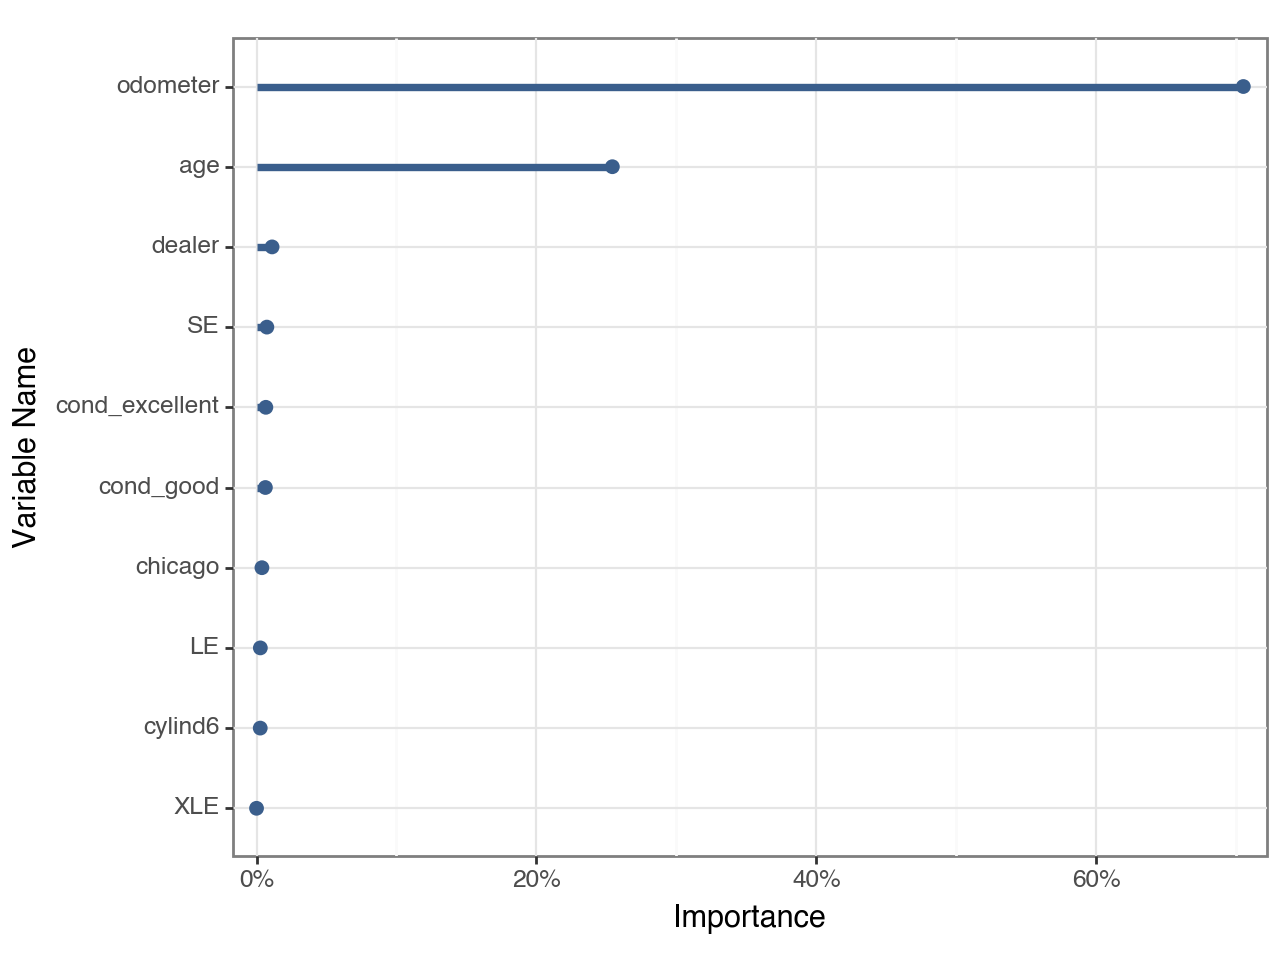

<Figure Size: (640 x 480)>

In [72]:
# Variable importance for model 6

cart6_var_imp_df = (
    pd.DataFrame(cart6.feature_importances_, feature_names_model2)
    .iloc[1:, :]
    .rename({0: "Importance"}, axis=1)
    .sort_values(by=["Importance"], ascending=False)
    .reset_index()
)
(
    ggplot(cart6_var_imp_df, aes(x="reorder(index,Importance)", y="Importance"))
    + geom_point(color=color[0], size=2)
    + geom_segment(
        aes(x="index", xend="index", y=0, yend="Importance"), color=color[0], size=1.5
    )
    + ylab("Importance")
    + xlab("Variable Name")
    + coord_flip()
    + scale_y_continuous(expand=(0.01, 0.01), labels=percent_format())
    + theme_bw()
)


In [74]:
pd.DataFrame(
    {
        "Model": ["CART M" + str(i) for i in range(1, 7)]
        + ["OLS M" + str(i) for i in range(1, 4)],
        "Number of variables": [1, 1, 7, 7, 7, 7, 1, 7, 7],
        "Model details": [
            "2 levels",
            "3 levels",
            "min_impurity_decrease=50000",
            "min_impurity_decrease=140000 & min_samples_split=20",
            "min_impurity_decrease=20000",
            "ccp_alpha=30000",
            "linear",
            "linear",
            "w/ polynomial terms",
        ],
        "RMSE": [
            rmse_cart1,
            rmse_cart2,
            rmse_cart3,
            rmse_cart4,
            rmse_cart5,
            rmse_cart6,
            rmse_ols1,
            rmse_linreg2,
            rmse_linreg3,
        ],
    }
).set_index("Model").round(2)


Number of variables  ...     RMSE
Model                         ...         
CART M1                    1  ...  3105.59
CART M2                    1  ...  2275.41
CART M3                    7  ...  1965.10
CART M4                    7  ...  1924.28
CART M5                    7  ...  1873.37
CART M6                    7  ...  1691.66
OLS M1                     1  ...  2377.29
OLS M2                     7  ...  1932.06
OLS M3                     7  ...  1425.68

[9 rows x 3 columns]